In [29]:
# IMPORTS
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import libs.forward_model as fm
import libs.read_data as rd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Parameters

In [20]:
# Parameter Definition
NA = .25
Rindex= 1
lambda_= 532.0/ 1000 #um
dx= 2.0 #um

Nx,Ny,Nz = 121,121,121

fm.init_parameters(NA_=NA, Rindex_=Rindex, lambda_=lambda_, dx_=dx, Nx_=Nx, Ny_=Ny, Nz_=Nz)
fm.init_DMD()
rd.init_parameters(Nx,Ny,Nz)

Sucessfully Initialized Point Spread Function...!!!
Sucessfully Initialized Read Data Parameters...!!!


### Forward Model

$$ H_1(x,y,z) = H(x,y,z=z_f)\ \star_{\tiny 3D}\ \texttt{exPSF}(x,y,z) \qquad\to\qquad H_2(x,y,z) = \|H_1(x,y,z)\|$$ 



$$H_3(x,y,z) = X(x,y,z) \circ H_2(x,y,z) \qquad \to \qquad Y(x,y,z) = \texttt{emPSF}(x,y,z)\ \star_{\tiny 3D}\ H_3(x,y,z)$$

The $\texttt{exPSF}(.)$ is modelled considering the coherance nature of laser light whereas the $\texttt{emPSF}(.)$ is defined in a incoherant manner<br>

Fluroscense bead data could be downloaded [here.](https://bigwww.epfl.ch/deconvolution/bead/)

Object Loaded Sucessfully...!!!


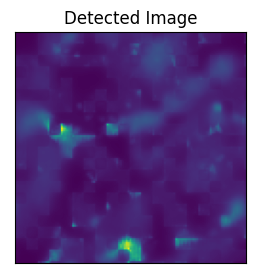

In [26]:
rd.load_object("blood_cell")   # Data Choices --> [blood_cell, neural_cell, bead, 3D_sphere]
det_img_orig = fm.forward_model(rd.X, verbose=1)

### Experiments on Data

***Effect of Center Plane: Neural Data***

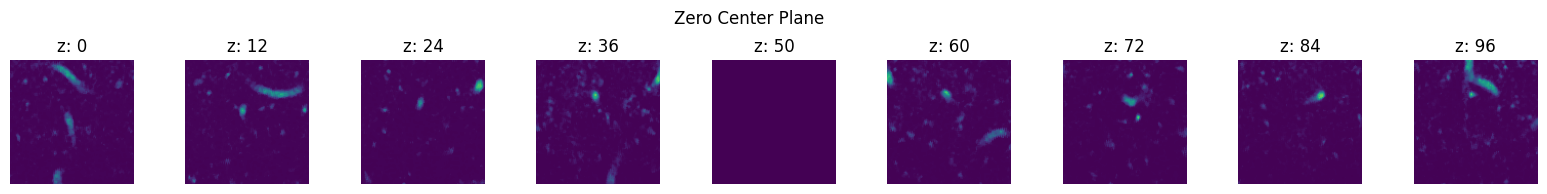

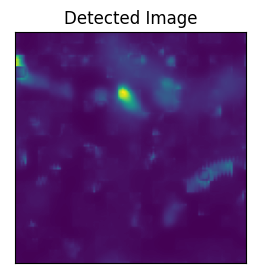

SSIM(Original, Maksed Center Plane) : 1.0


In [23]:
X_e1 = rd.X.clone()
X_e1[0,40:60,:,:] = 0
fm.show_planes_z(X_e1.detach().cpu().numpy()[0,:,:,:],"Zero Center Plane",[0,12,24,36,50, 60,72,84,96])
det_img_e1=fm.forward_model(rd.X,verbose=1)
print(f"SSIM(Original, Maksed Center Plane) : {ssim(det_img_orig.detach().cpu().float().numpy(),det_img_e1.detach().cpu().float().numpy())}")

***Only the Center Plane is Non-Zero***

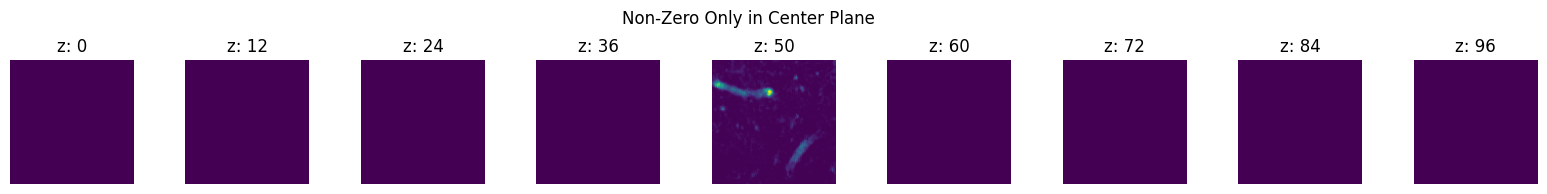

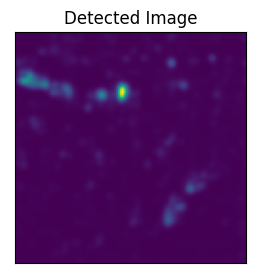

SSIM(Original, Focal Plane Object) : 0.9871099941716979


In [24]:
X_e2 = rd.X.clone()
X_e2[0,:50,:,:] = 0
X_e2[0,51:,:,:] = 0
fm.show_planes_z(X_e2.detach().cpu().numpy()[0,:,:,:],"Non-Zero Only in Center Plane",[0,12,24,36,50, 60,72,84,96])
det_img_e2=fm.forward_model(X_e2,verbose = 1)
print(f"SSIM(Original, Focal Plane Object) : {ssim(det_img_orig.detach().cpu().float().numpy(),det_img_e2.detach().cpu().float().numpy())}")

***Slice-wise Comparision***

Mask Out z=0	->   z=8,	 SSIM_score = 0.9999299294240984 
Mask Out z=8	->   z=16,	 SSIM_score = 0.9999047284631062 
Mask Out z=16	->   z=24,	 SSIM_score = 0.9999197713503991 
Mask Out z=24	->   z=32,	 SSIM_score = 0.9999690986986647 
Mask Out z=32	->   z=40,	 SSIM_score = 0.9999517665423157 
Mask Out z=40	->   z=48,	 SSIM_score = 0.999854711246851 
Mask Out z=48	->   z=56,	 SSIM_score = 0.9998093675710754 
Mask Out z=56	->   z=64,	 SSIM_score = 0.9988814992174534 
Mask Out z=64	->   z=72,	 SSIM_score = 0.9999015656491083 
Mask Out z=72	->   z=80,	 SSIM_score = 0.9999607549182409 
Mask Out z=80	->   z=88,	 SSIM_score = 0.9999440271236946 
Mask Out z=88	->   z=96,	 SSIM_score = 0.9998859848146853 
Mask Out z=96	->   z=104,	 SSIM_score = 0.9998180874894833 
Mask Out z=104	->   z=112,	 SSIM_score = 0.9999753932736546 
Mask Out z=112	->   z=120,	 SSIM_score = 0.9999964137203526 
Mask Out z=120	->   z=128,	 SSIM_score = 0.9999999602710817 


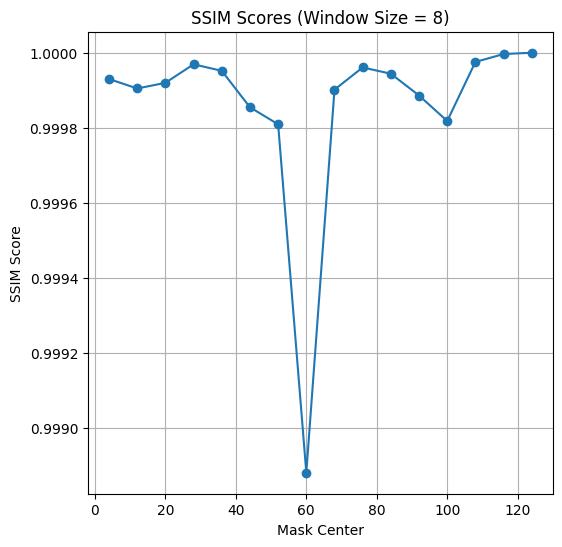

In [25]:
SSIM_list = []
mask_centers = []
ws = 8 # WINDOWSIZE

for mask in range(Nz//ws+1):
    X_exp = rd.X.clone()
    X_exp[0,mask*ws:(mask+1)*ws,:,:] = 0
    det_img_exp = fm.forward_model(X_exp)
    SSIM_score = ssim(det_img_orig.detach().cpu().float().numpy(),det_img_exp.detach().cpu().float().numpy())
    SSIM_list.append(SSIM_score), mask_centers.append(mask*ws+ws/2)
    print(f"Mask Out z={mask*ws}\t->   z={(mask+1)*ws},\t SSIM_score = {SSIM_score} ")

plt.figure(figsize=(6, 6))  # Adjust the figure size if needed
plt.plot(mask_centers, SSIM_list, marker='o', linestyle='-')
plt.title(f'SSIM Scores (Window Size = {ws})')
plt.xlabel('Mask Center')
plt.ylabel('SSIM Score')
plt.grid(True)


## Approximation of A

$$Y_{\tiny N_x\cdot N_y\cdot m\times1} = A_{\tiny N_x\cdot N_y\cdot m\times N_x\cdot N_y\cdot N_z}\cdot X_{\tiny N_x\cdot N_y\cdot N_z\times 1}$$

In [50]:
# Parameter Definition
NA = .25
Rindex= 1
lambda_= 532.0/ 1000 #um
dx= 2.0 #um

Nx,Ny,Nz = 4,4,4
m = 4

fm.init_parameters(NA_=NA, Rindex_=Rindex, lambda_=lambda_, dx_=dx, Nx_=Nx, Ny_=Ny, Nz_=Nz)
fm.init_DMD_patterns(m)
rd.init_parameters(Nx,Ny,Nz)

Sucessfully Initialized Point Spread Function...!!!
Sucessfully Initialized Read Data Parameters...!!!


In [51]:
fm.init_one_shot(m)
def one_shot_model(X):
    return torch.matmul(fm.A,X)

Matrix A is intialized sucessfully...!!!


### Visualization and Verification of A

***Visualization of A***

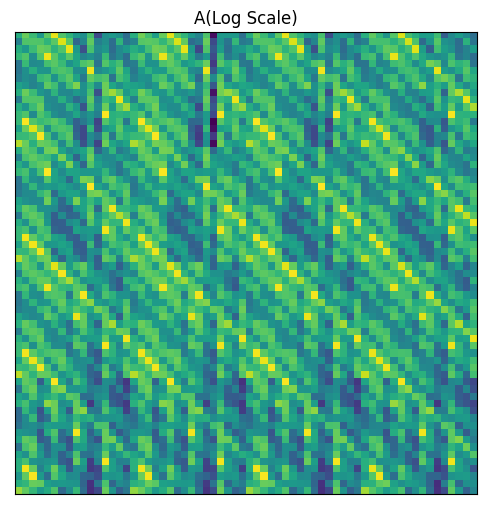

In [52]:
A_ = fm.A.detach().cpu().numpy()
A_[A_==0] = 1e-30
A_ = np.log(A_)
fm.show_image(A_,fig_size=(6,6),title="A(Log Scale)")

***Verification of A***

Object Loaded Sucessfully...!!!


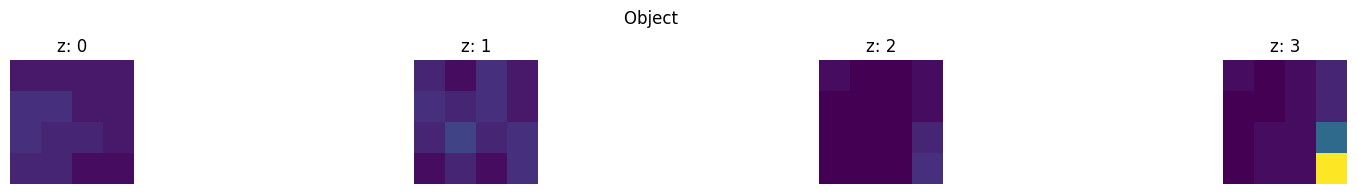

In [60]:
rd.load_object('blood_cell')
fm.show_planes(rd.X[0].detach().cpu().numpy(),'Object',Nz)


In [61]:
Y1 = fm.extended_forward_model(rd.X)
Y2 = one_shot_model(rd.X.flatten())

tolerance = 1e-6
are_approx_equal = torch.allclose(Y1, Y2, atol=tolerance)

if are_approx_equal:
    print("The vectors are approximately the same.")
else:
    print("The vectors are different.")

The vectors are approximately the same.
